In [1]:
try :
    import flax.linen as nn
except:
    %pip install -q flax
    import flax.linen as nn

from flax.core import unfreeze

from flax.training import train_state 

import jax
import jax.numpy as jnp
from jax.config import config
import optax

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_moons
# from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve

from functools import partial


In [2]:
config.update("jax_enable_x64", True)

In [3]:
X,Y =  make_moons(200, noise=0.2, random_state=1)

X.shape,Y.shape

((200, 2), (200,))

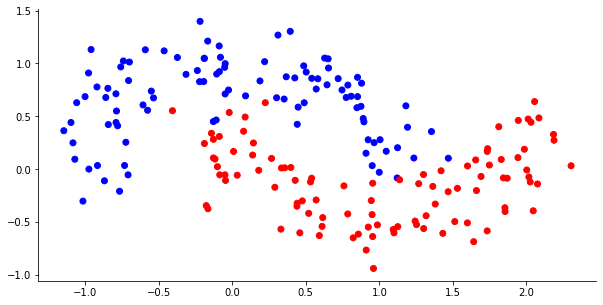

In [4]:
plt.figure(figsize=[10,5])
plt.scatter(X[:,0],X[:,1], c=Y, cmap='bwr')
sns.despine()

In [5]:
class mlp(nn.Module):
    features: list

    @nn.compact
    def __call__(self, X, deterministic, rate = 0.03):
        for i, feature in enumerate(self.features):
            X = nn.Dense(feature, name=f"Dense_{i}")(X)
            if i != 0 and i != len(self.features) - 1:
                X = nn.relu(X)
                X = nn.Dropout(rate=rate, deterministic=deterministic, name=f"Dense_{i}_dropout")(X)
        return X

    def loss_fn(self, params, X, y, deterministic=False, rate=0.03, rng=jax.random.PRNGKey(0)):
        logits = self.apply(params, X, deterministic=False, rate=rate, rngs={"dropout": rng})
        y_pred = nn.sigmoid(logits)
        cost0 = jnp.dot(y.T, jnp.log(y_pred + 1e-7))
        cost1 = jnp.dot((1 - y).T, jnp.log(1 - y_pred + 1e-7))
        loss = (cost0 + cost1)/len(X)
        return -loss.squeeze()


In [6]:
def fit(model, params, auxs, learning_rate = 0.01, epochs=1000, random_seed = 0, verbose=False):

    rng = jax.random.PRNGKey(random_seed)

    opt = optax.adam(learning_rate=learning_rate)
    opt_state = opt.init(params)

    loss_fn = partial(model.loss_fn, **auxs)
    loss_grad_fn = jax.value_and_grad(loss_fn)
    losses = []

    @jax.jit
    def one_epoch(params, opt_state, rng):
        loss_val, grads = loss_grad_fn(params, rng=rng)
        updates, opt_state = opt.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_val

    try:
        for i in range(epochs):
            rng, _ = jax.random.split(rng)
            params, opt_state, loss_val = one_epoch(params, opt_state, rng)
            losses.append(loss_val)
            if verbose and i % (epochs / 10) == 0:
                print('Loss step {}: '.format(i), loss_val)
    except KeyboardInterrupt:
        print(f"Completed {i} epochs.")
        return params, jnp.array(losses)    

    return params, jnp.array(losses)

In [7]:
model = mlp([16, 32, 64, 32, 16, 1])

In [8]:
params = model.init(jax.random.PRNGKey(0), X, True)

In [9]:
auxs = {
    "X":X,
    "y":Y,
    "deterministic":False
}
params, loss = fit(model, params, auxs, learning_rate=0.01, epochs=100, verbose=True)

Loss step 0:  0.6957294626396479
Loss step 10:  0.291266586952397
Loss step 20:  0.2567659453056879
Loss step 30:  0.19874514579431046
Loss step 40:  0.14722303939824521
Loss step 50:  0.1305535973468076
Loss step 60:  0.09695527651945937
Loss step 70:  0.07246698872080193
Loss step 80:  0.05416560871174104
Loss step 90:  0.05672778391007703


In [10]:
logits = model.apply(params, X, deterministic=True)
y_pred = nn.sigmoid(logits)

In [11]:
y_hat = (y_pred >= 0.5).astype(int)

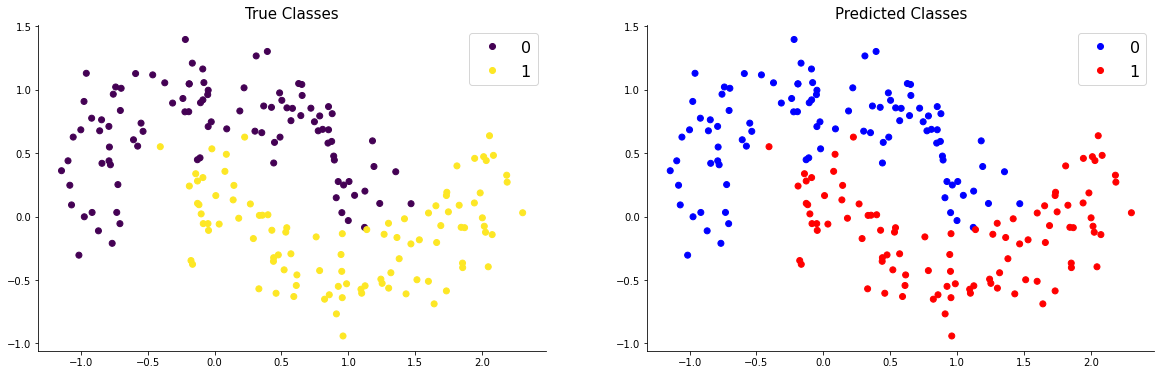

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(20,6))

ax[0].set_title("True Classes", fontsize=15)
hs = ax[0].scatter(X[:, 0], X[:, 1], c = Y)
ax[0].legend(*hs.legend_elements(), fontsize=16)

ax[1].set_title("Predicted Classes", fontsize=15)
hs = ax[1].scatter(X[:,0], X[:,1], c=y_hat, cmap="bwr")
ax[1].legend(*hs.legend_elements(), fontsize=16)
sns.despine()

In [1]:
# plt.figure(figsize=(12, 6))
# plt.title("Calibration Plot", fontsize=16)
# plt.plot(jnp.arange(0, 1.1, 0.1), jnp.arange(0, 1.1, 0.1), "k--", label="Perfectly Calibrated")
# prob_true, prob_pred = calibration_curve(Y, y_pred, n_bins=5)
# # plt.plot(prob_pred, prob_true)
# plt.plot(prob_pred, prob_true, "-o", markersize=10, label="dropout_mlp")
# plt.legend(fontsize=15)
# sns.despine()
# plt.show()

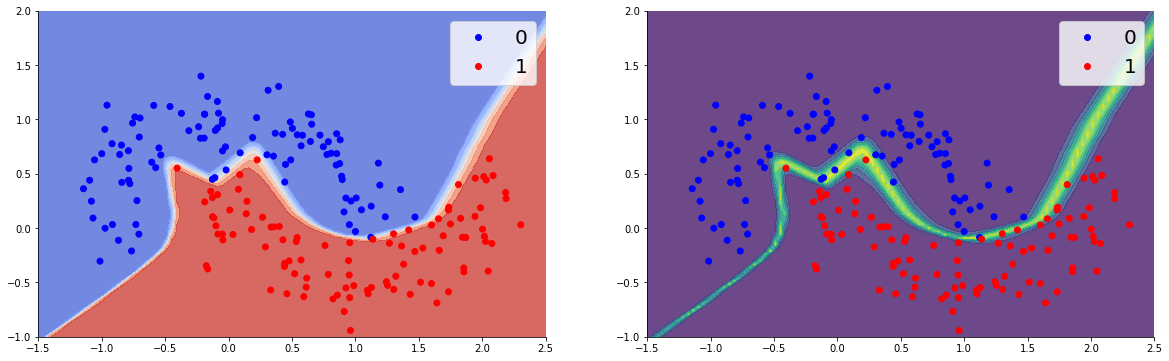

In [14]:
xx1 = jnp.linspace(-1.5, 2.5, 100)
xx2 = jnp.linspace(-1.0, 2, 100)
XX1, XX2 = jnp.meshgrid(xx1, xx2)

Z = nn.sigmoid(model.apply(params, jnp.c_[XX1.ravel(), XX2.ravel()], deterministic=True))
Z = Z.reshape(XX1.shape)
sigma_Z = Z*(1-Z)

fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].contourf(XX1, XX2, Z, cmap="coolwarm", alpha=0.8)
hs = ax[0].scatter(X[:,0], X[:,1], c=y_hat, cmap="bwr")
ax[0].legend(*hs.legend_elements(), fontsize=20)


ax[1].contourf(XX1, XX2, sigma_Z, alpha=0.8)
hs = ax[1].scatter(X[:,0], X[:,1], c=y_hat, cmap="bwr")
ax[1].legend(*hs.legend_elements(), fontsize=20)

sns.despine()

In [15]:
xx1 = jnp.linspace(-2.5, 3.5, 200)
xx2 = jnp.linspace(-2.0, 3, 200)
XX1, XX2 = jnp.meshgrid(xx1, xx2)
y_stacks = []

@jax.jit
def func(params, i):
    z = nn.sigmoid(model.apply(params, jnp.c_[XX1.ravel(), XX2.ravel()], deterministic=False, 
                    rngs={"dropout": jax.random.PRNGKey(i)}))
    return z
y_stacks = jax.vmap(fun=func, in_axes=(None, 0))(params, jnp.arange(100))

In [16]:
Z = jnp.array(y_stacks).mean(axis=0)
sigma_Z = jnp.array(y_stacks).std(axis=0)
Z = Z.reshape(XX1.shape)
sigma_Z = sigma_Z.reshape(XX1.shape)

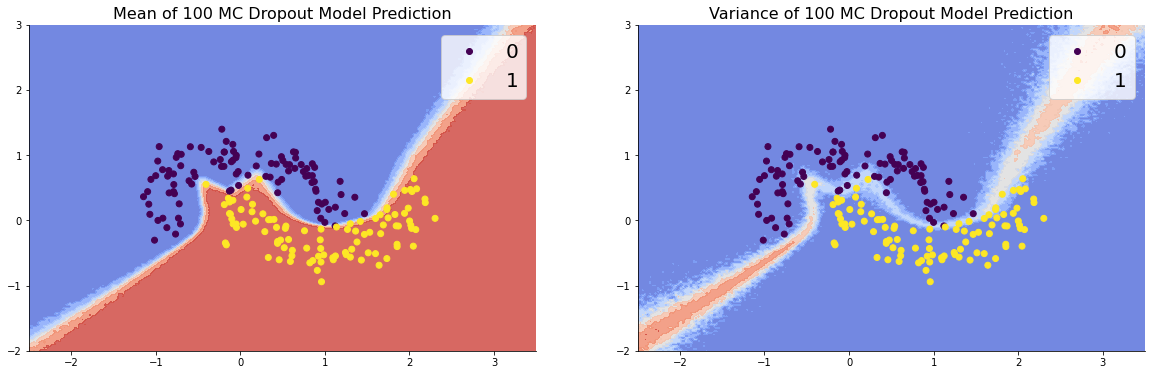

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].set_title("Mean of 100 MC Dropout Model Prediction", fontsize=16)
ax[0].contourf(XX1, XX2, Z, cmap="coolwarm", alpha=0.8)
hs = ax[0].scatter(X[:,0], X[:,1], c=y_hat)
ax[0].legend(*hs.legend_elements(), fontsize=20)

ax[1].set_title("Variance of 100 MC Dropout Model Prediction", fontsize=16)
ax[1].contourf(XX1, XX2, sigma_Z, cmap="coolwarm", alpha=0.8)
hs = ax[1].scatter(X[:,0], X[:,1], c=y_hat)
ax[1].legend(*hs.legend_elements(), fontsize=20)
sns.despine()